In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time
import warnings
from collections import deque
import psutil
import os

In [2]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
FILE_PATH = '/mnt/sda3/dataset_AMC /radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5'
JSON_PATH = '/mnt/sda3/dataset_AMC /radioml2018/versions/2/classes-fixed.json'

TARGET_MODULATIONS = [
    'OOK','BPSK', 'QPSK', '8PSK','16QAM','GMSK' #,'AM-SSB-WC'
]

BATCH_SIZE = 256 # adjust to my laptop 
#LEARNING_RATE = 0.003 
NUM_EPOCHS = 100 
NUM_WORKERS = 0 #Temporary check it  

INPUT_CHANNELS = 2 
SEQUENCE_LENGTH = 1024 
NUM_CLASSES = 6 # adjust this to 

# TRAIN_RATIO = 0.7 
# VALID_RATIO = 0.2 
# TEST_RATIO = 0.1 

nf_train = int(BATCH_SIZE * 0.7)
nf_valid = int(BATCH_SIZE * 0.2)
nf_test  = BATCH_SIZE - nf_train - nf_valid

print("📋 Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
#print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

📋 Training Parameters:
  Batch size: 256
  Epochs: 100


In [4]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.8, # training 70 %
                  valid_proportion=0.2, # validation 20 %
                  test_proportion=0.0, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [5]:
class RadioML18Dataset(Dataset):
    def __init__(self, mode: str,use_fft: bool = False, seed=48,):
        super(RadioML18Dataset, self).__init__()

        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft 
        try:
            hdf5_file = h5py.File(self.file_path, 'r') #Escaped backslashes 
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except Exception as e: 
            print(f"Error loading file : {e}")
            raise e 
        
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]

        train_proportion=(6*26*nf_train)/self.X.shape[0]
        valid_proportion=(6*26*nf_valid)/self.X.shape[0]
        test_proportion=(6*26*nf_test)/self.X.shape[0]

        self.target_snrs = np.unique(self.Z)

        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_proportion,
                                                                  valid_proportion = valid_proportion,
                                                                  test_proportion = test_proportion,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )

        # *** CRITICAL FIX: Apply I/Q swap correction for AMC compatibility ***
        print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
 
        self.X_data = self.X_data[:,:,[1,0]]
        print(f"✅ I/Q channels corrected for real-world compatibility")
        if self.use_fft:
            print("Dataset configured to use FFT as input")

        # store statistic of whole dataset (unchanged)
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x_raw,y,z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        
        # convert to tensor adn transpose to (channels and sequence length)
        x = torch.from_numpy(x_raw).float().transpose(0,1)

        if self.use_fft: 
            complex_signal = torch.complex(x[0],x[1])
            fft_result = torch.fft.fft(complex_signal)

            fft_real = torch.real(fft_result)
            fft_imag = torch.imag(fft_result)

            x = torch.stack([fft_real,fft_imag], dim = 0)
        
        return x,y,z

In [6]:
try:
    from BaseCNN import create_BaseCNN_NET

    # Match the real signature: (n_labels, dropout_rate)
    model = create_BaseCNN_NET(n_labels=NUM_CLASSES, dropout_rate=0.5).to(device)
    print("✅ Successfully built BaseCNN:", model)

except Exception as e:
    print(f"⚠️ Could not build BaseCNN: {e}")

✅ Successfully built BaseCNN: BaseCNN_NET(
  (backbone): Sequential(
    (0): BaseCNN_Block(
      (block): Sequential(
        (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Dropout(p=0.2, inplace=False)
      )
    )
    (1): BaseCNN_Block(
      (block): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): Batch

/home/lipplopp/anaconda3/envs/ai_sdr/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_3412/2603725079.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
Datasets loaded successfully.
Total dataset size: 6864
Train dataset size: 5491 (80%)
Validation dataset size: 1373 (20%)

Starting training...


Training:   0%|                      | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_3412/2603725079.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.61it/s]
                                                            
Epochs:   1%|▎                                  | 1/100 [00:01<02:20,  1.42s/it]

Epoch 1/100: Train Loss: 1.5232 | Train Acc: 33.75% | Valid Loss: 1.6305 | Valid Acc: 27.17%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:   2%|▋                                  | 2/100 [00:02<01:57,  1.20s/it]

Epoch 2/100: Train Loss: 1.1649 | Train Acc: 49.15% | Valid Loss: 0.9882 | Valid Acc: 55.72%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:   3%|█                                  | 3/100 [00:03<01:50,  1.14s/it]

Epoch 3/100: Train Loss: 0.9666 | Train Acc: 57.44% | Valid Loss: 0.9067 | Valid Acc: 60.89%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:   4%|█▍                                 | 4/100 [00:04<01:46,  1.11s/it]

Epoch 4/100: Train Loss: 0.8902 | Train Acc: 59.46% | Valid Loss: 1.1070 | Valid Acc: 60.23%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:   5%|█▊                                 | 5/100 [00:05<01:43,  1.09s/it]

Epoch 5/100: Train Loss: 0.8379 | Train Acc: 62.27% | Valid Loss: 0.7902 | Valid Acc: 64.24%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:   6%|██                                 | 6/100 [00:06<01:42,  1.09s/it]

Epoch 6/100: Train Loss: 0.8157 | Train Acc: 64.38% | Valid Loss: 0.8319 | Valid Acc: 64.09%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:   7%|██▍                                | 7/100 [00:07<01:40,  1.08s/it]

Epoch 7/100: Train Loss: 0.7693 | Train Acc: 66.60% | Valid Loss: 0.7374 | Valid Acc: 66.57%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:   8%|██▊                                | 8/100 [00:08<01:39,  1.08s/it]

Epoch 8/100: Train Loss: 0.7306 | Train Acc: 68.71% | Valid Loss: 0.7256 | Valid Acc: 68.46%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:   9%|███▏                               | 9/100 [00:09<01:38,  1.09s/it]

Epoch 9/100: Train Loss: 0.7025 | Train Acc: 70.02% | Valid Loss: 0.7012 | Valid Acc: 70.36%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:  10%|███▍                              | 10/100 [00:11<01:37,  1.09s/it]

Epoch 10/100: Train Loss: 0.6925 | Train Acc: 70.55% | Valid Loss: 0.7423 | Valid Acc: 67.23%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:  11%|███▋                              | 11/100 [00:12<01:36,  1.09s/it]

Epoch 11/100: Train Loss: 0.6871 | Train Acc: 70.10% | Valid Loss: 0.7177 | Valid Acc: 69.63%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:  12%|████                              | 12/100 [00:13<01:35,  1.09s/it]

Epoch 12/100: Train Loss: 0.6918 | Train Acc: 69.86% | Valid Loss: 0.8681 | Valid Acc: 69.63%



Training:   0%|                      | 0/22 [00:00<?, ?it/s]
                                                            
Epochs:  13%|████▍                             | 13/100 [00:14<01:34,  1.09s/it]

Epoch 13/100: Train Loss: 0.6695 | Train Acc: 71.37% | Valid Loss: 0.7009 | Valid Acc: 68.83%



Training:  95%|████████████▍| 21/22 [00:01<00:00, 20.76it/s]
                                                            
Epochs:  14%|████▊                             | 14/100 [00:15<01:35,  1.11s/it]

Epoch 14/100: Train Loss: 0.6785 | Train Acc: 70.77% | Valid Loss: 0.6497 | Valid Acc: 70.65%



Training:  95%|████████████▍| 21/22 [00:01<00:00, 20.83it/s]
                                                            
Epochs:  15%|█████                             | 15/100 [00:16<01:34,  1.12s/it]

Epoch 15/100: Train Loss: 0.6723 | Train Acc: 70.82% | Valid Loss: 0.7400 | Valid Acc: 69.26%



Training:  91%|███████████▊ | 20/22 [00:01<00:00, 19.72it/s]
                                                            
Epochs:  16%|█████▍                            | 16/100 [00:17<01:35,  1.14s/it]

Epoch 16/100: Train Loss: 0.6517 | Train Acc: 71.74% | Valid Loss: 0.6417 | Valid Acc: 71.74%



Training:  91%|███████████▊ | 20/22 [00:01<00:00, 19.68it/s]
                                                            
Epochs:  17%|█████▊                            | 17/100 [00:19<01:35,  1.16s/it]

Epoch 17/100: Train Loss: 0.6598 | Train Acc: 72.06% | Valid Loss: 0.6909 | Valid Acc: 71.01%



Training:  86%|███████████▏ | 19/22 [00:01<00:00, 18.18it/s]
                                                            
Epochs:  18%|██████                            | 18/100 [00:20<01:38,  1.21s/it]

Epoch 18/100: Train Loss: 0.6794 | Train Acc: 70.41% | Valid Loss: 0.6513 | Valid Acc: 70.79%



Training:  95%|████████████▍| 21/22 [00:01<00:00, 20.25it/s]
                                                            
Epochs:  19%|██████▍                           | 19/100 [00:21<01:37,  1.20s/it]

Epoch 19/100: Train Loss: 0.6369 | Train Acc: 72.34% | Valid Loss: 0.6536 | Valid Acc: 70.14%



Training:  86%|███████████▏ | 19/22 [00:01<00:00, 18.86it/s]
                                                            
Epochs:  20%|██████▊                           | 20/100 [00:22<01:38,  1.23s/it]

Epoch 20/100: Train Loss: 0.6353 | Train Acc: 72.94% | Valid Loss: 0.6322 | Valid Acc: 72.25%



Training:  86%|███████████▏ | 19/22 [00:01<00:00, 18.76it/s]
                                                            
Epochs:  21%|███████▏                          | 21/100 [00:24<01:38,  1.24s/it]

Epoch 21/100: Train Loss: 0.6383 | Train Acc: 72.76% | Valid Loss: 0.6192 | Valid Acc: 72.18%



Training:  82%|██████████▋  | 18/22 [00:01<00:00, 17.87it/s]
                                                            
Epochs:  22%|███████▍                          | 22/100 [00:25<01:38,  1.26s/it]

Epoch 22/100: Train Loss: 0.6399 | Train Acc: 71.70% | Valid Loss: 0.6188 | Valid Acc: 71.38%



Training:  82%|██████████▋  | 18/22 [00:01<00:00, 17.87it/s]
                                                            
Epochs:  23%|███████▊                          | 23/100 [00:26<01:38,  1.28s/it]

Epoch 23/100: Train Loss: 0.6273 | Train Acc: 72.50% | Valid Loss: 0.6354 | Valid Acc: 71.09%



Training:  91%|███████████▊ | 20/22 [00:01<00:00, 19.03it/s]
                                                            
Epochs:  24%|████████▏                         | 24/100 [00:27<01:36,  1.27s/it]

Epoch 24/100: Train Loss: 0.6236 | Train Acc: 73.19% | Valid Loss: 0.6490 | Valid Acc: 72.25%



Training:  91%|███████████▊ | 20/22 [00:01<00:00, 18.99it/s]
                                                            
Epochs:  25%|████████▌                         | 25/100 [00:29<01:34,  1.26s/it]

Epoch 25/100: Train Loss: 0.6219 | Train Acc: 73.34% | Valid Loss: 0.6147 | Valid Acc: 72.69%



Training:  91%|███████████▊ | 20/22 [00:01<00:00, 19.04it/s]
                                                            
Epochs:  26%|████████▊                         | 26/100 [00:30<01:32,  1.26s/it]

Epoch 26/100: Train Loss: 0.6272 | Train Acc: 73.08% | Valid Loss: 0.7104 | Valid Acc: 71.81%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.84it/s]
                                                            
Epochs:  27%|█████████▏                        | 27/100 [00:31<01:34,  1.30s/it]

Epoch 27/100: Train Loss: 0.6223 | Train Acc: 73.43% | Valid Loss: 0.6430 | Valid Acc: 71.81%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.70it/s]
                                                            
Epochs:  28%|█████████▌                        | 28/100 [00:33<01:37,  1.35s/it]

Epoch 28/100: Train Loss: 0.6167 | Train Acc: 73.41% | Valid Loss: 0.7063 | Valid Acc: 70.21%



Training:  82%|██████████▋  | 18/22 [00:01<00:00, 17.84it/s]
                                                            
Epochs:  29%|█████████▊                        | 29/100 [00:34<01:36,  1.36s/it]

Epoch 29/100: Train Loss: 0.6303 | Train Acc: 72.83% | Valid Loss: 0.6383 | Valid Acc: 70.94%



Training:  82%|██████████▋  | 18/22 [00:01<00:00, 17.08it/s]
                                                            
Epochs:  30%|██████████▏                       | 30/100 [00:36<01:36,  1.38s/it]

Epoch 30/100: Train Loss: 0.6192 | Train Acc: 73.57% | Valid Loss: 0.6616 | Valid Acc: 71.67%



Training:  82%|██████████▋  | 18/22 [00:01<00:00, 17.26it/s]
                                                            
Epochs:  31%|██████████▌                       | 31/100 [00:37<01:35,  1.38s/it]

Epoch 31/100: Train Loss: 0.6255 | Train Acc: 73.08% | Valid Loss: 0.6333 | Valid Acc: 71.89%



Training:  82%|██████████▋  | 18/22 [00:01<00:00, 17.25it/s]
                                                            
Epochs:  32%|██████████▉                       | 32/100 [00:38<01:34,  1.39s/it]

Epoch 32/100: Train Loss: 0.6192 | Train Acc: 73.43% | Valid Loss: 0.6330 | Valid Acc: 71.16%



Training:  77%|██████████   | 17/22 [00:01<00:00, 16.54it/s]
                                                            
Epochs:  33%|███████████▏                      | 33/100 [00:40<01:33,  1.39s/it]

Epoch 33/100: Train Loss: 0.6028 | Train Acc: 74.34% | Valid Loss: 0.6356 | Valid Acc: 71.30%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.31it/s]
                                                            
Epochs:  34%|███████████▌                      | 34/100 [00:41<01:33,  1.42s/it]

Epoch 34/100: Train Loss: 0.6058 | Train Acc: 73.83% | Valid Loss: 0.6263 | Valid Acc: 72.10%



Training:  86%|███████████▏ | 19/22 [00:01<00:00, 18.58it/s]
                                                            
Epochs:  34%|███████████▌                      | 34/100 [00:43<01:23,  1.27s/it]


Early stopping at epoch 35

Training complete.
Best validation accuracy: 72.69%


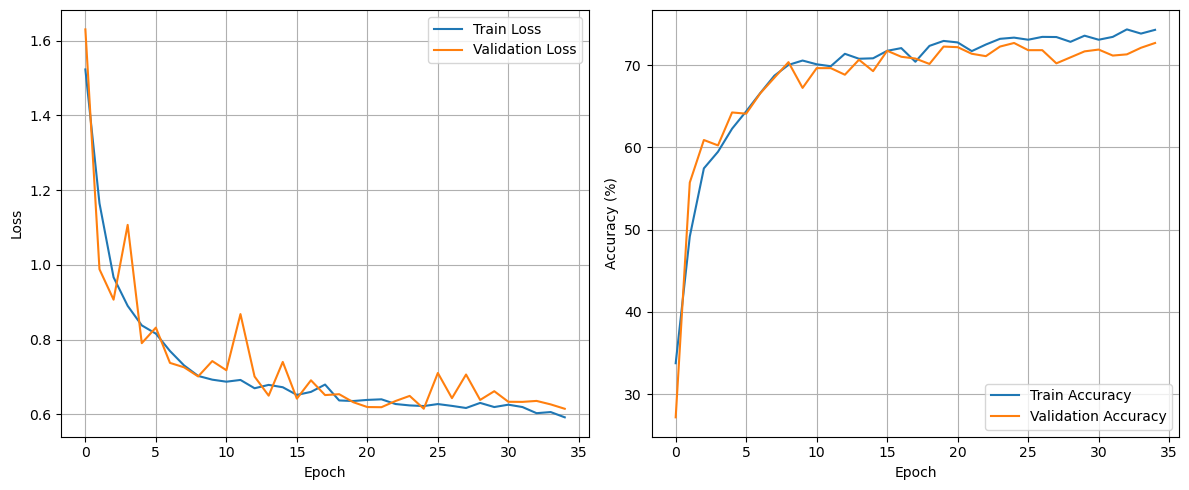

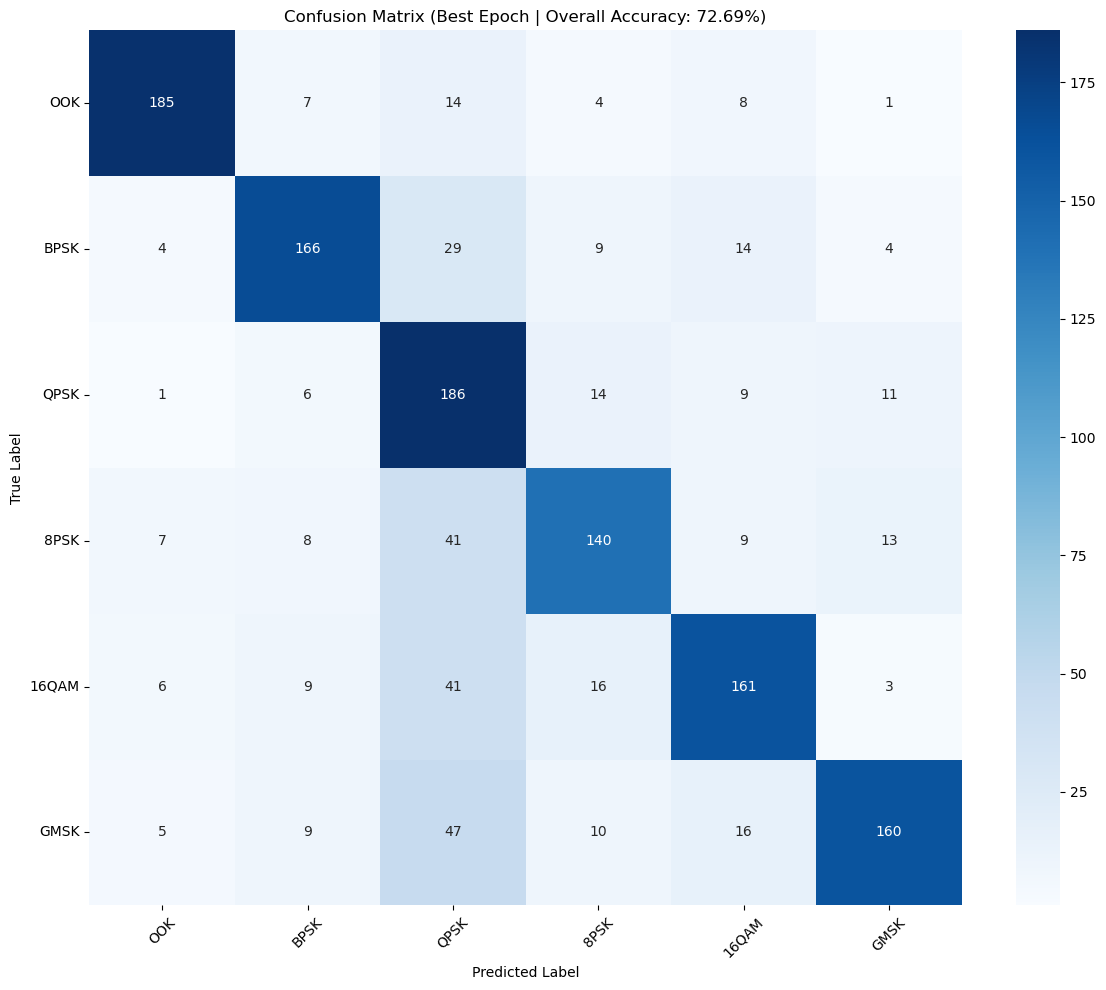

In [7]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    patience=5, 
    factor=0.5,
    verbose=True
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioML18Dataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model2.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix.png')
plt.show()

/home/lipplopp/anaconda3/envs/ai_sdr/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_3412/3669632045.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility
Dataset configured to use FFT as input
Datasets loaded successfully.
Total dataset size: 6864
Train dataset size: 5491 (80%)
Validation dataset size: 1373 (20%)

Starting training...


Training:   0%|                      | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_3412/3669632045.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training:  86%|███████████▏ | 19/22 [00:01<00:00, 17.92it/s]
                                                            
Epochs:   1%|▎                                  | 1/100 [00:01<02:21,  1.43s/it]

Epoch 1/100: Train Loss: 3.9156 | Train Acc: 17.37% | Valid Loss: 1.8639 | Valid Acc: 22.65%



Training:  77%|██████████   | 17/22 [00:01<00:00, 16.54it/s]
                                                            
Epochs:   2%|▋                                  | 2/100 [00:02<02:26,  1.49s/it]

Epoch 2/100: Train Loss: 1.8663 | Train Acc: 20.85% | Valid Loss: 1.7613 | Valid Acc: 19.74%



Training:  77%|██████████   | 17/22 [00:01<00:00, 16.39it/s]
                                                            
Epochs:   3%|█                                  | 3/100 [00:04<02:26,  1.51s/it]

Epoch 3/100: Train Loss: 1.6699 | Train Acc: 24.90% | Valid Loss: 1.6414 | Valid Acc: 26.44%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.69it/s]
                                                            
Epochs:   4%|█▍                                 | 4/100 [00:06<02:27,  1.54s/it]

Epoch 4/100: Train Loss: 1.6048 | Train Acc: 26.44% | Valid Loss: 1.5801 | Valid Acc: 27.31%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.08it/s]
                                                            
Epochs:   5%|█▊                                 | 5/100 [00:07<02:25,  1.53s/it]

Epoch 5/100: Train Loss: 1.5758 | Train Acc: 27.34% | Valid Loss: 1.5615 | Valid Acc: 26.95%



Training:  68%|████████▊    | 15/22 [00:01<00:00, 14.23it/s]
                                                            
Epochs:   6%|██                                 | 6/100 [00:09<02:25,  1.55s/it]

Epoch 6/100: Train Loss: 1.5616 | Train Acc: 28.45% | Valid Loss: 1.5443 | Valid Acc: 27.02%



Training:  64%|████████▎    | 14/22 [00:01<00:00, 13.77it/s]
                                                            
Epochs:   7%|██▍                                | 7/100 [00:10<02:27,  1.58s/it]

Epoch 7/100: Train Loss: 1.5399 | Train Acc: 28.32% | Valid Loss: 1.5268 | Valid Acc: 27.82%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.14it/s]
                                                            
Epochs:   8%|██▊                                | 8/100 [00:12<02:26,  1.59s/it]

Epoch 8/100: Train Loss: 1.5274 | Train Acc: 28.28% | Valid Loss: 1.5102 | Valid Acc: 28.11%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.27it/s]
                                                            
Epochs:   9%|███▏                               | 9/100 [00:14<02:25,  1.60s/it]

Epoch 9/100: Train Loss: 1.5120 | Train Acc: 28.21% | Valid Loss: 1.5022 | Valid Acc: 27.75%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.97it/s]
                                                            
Epochs:  10%|███▍                              | 10/100 [00:15<02:23,  1.60s/it]

Epoch 10/100: Train Loss: 1.4987 | Train Acc: 28.68% | Valid Loss: 1.4997 | Valid Acc: 26.95%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 14.97it/s]
                                                            
Epochs:  11%|███▋                              | 11/100 [00:17<02:22,  1.60s/it]

Epoch 11/100: Train Loss: 1.4920 | Train Acc: 29.34% | Valid Loss: 1.4862 | Valid Acc: 28.26%



Training:  68%|████████▊    | 15/22 [00:01<00:00, 14.57it/s]
                                                            
Epochs:  12%|████                              | 12/100 [00:18<02:21,  1.61s/it]

Epoch 12/100: Train Loss: 1.4936 | Train Acc: 28.54% | Valid Loss: 1.4891 | Valid Acc: 29.13%



Training:  68%|████████▊    | 15/22 [00:01<00:00, 14.53it/s]
                                                            
Epochs:  13%|████▍                             | 13/100 [00:20<02:20,  1.61s/it]

Epoch 13/100: Train Loss: 1.4854 | Train Acc: 29.10% | Valid Loss: 1.4739 | Valid Acc: 30.30%



Training:  68%|████████▊    | 15/22 [00:01<00:00, 14.17it/s]
                                                            
Epochs:  14%|████▊                             | 14/100 [00:22<02:20,  1.64s/it]

Epoch 14/100: Train Loss: 1.4830 | Train Acc: 30.14% | Valid Loss: 1.4779 | Valid Acc: 27.75%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.23it/s]
                                                            
Epochs:  15%|█████                             | 15/100 [00:23<02:19,  1.64s/it]

Epoch 15/100: Train Loss: 1.4801 | Train Acc: 29.45% | Valid Loss: 1.4763 | Valid Acc: 28.04%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.10it/s]
                                                            
Epochs:  16%|█████▍                            | 16/100 [00:25<02:17,  1.63s/it]

Epoch 16/100: Train Loss: 1.4766 | Train Acc: 29.63% | Valid Loss: 1.4707 | Valid Acc: 29.93%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.91it/s]
                                                            
Epochs:  17%|█████▊                            | 17/100 [00:27<02:14,  1.62s/it]

Epoch 17/100: Train Loss: 1.4795 | Train Acc: 30.38% | Valid Loss: 1.4775 | Valid Acc: 27.82%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.21it/s]
                                                            
Epochs:  18%|██████                            | 18/100 [00:28<02:12,  1.61s/it]

Epoch 18/100: Train Loss: 1.4674 | Train Acc: 30.30% | Valid Loss: 1.4640 | Valid Acc: 30.30%



Training:  77%|██████████   | 17/22 [00:01<00:00, 16.54it/s]
                                                            
Epochs:  19%|██████▍                           | 19/100 [00:30<02:06,  1.57s/it]

Epoch 19/100: Train Loss: 1.4688 | Train Acc: 30.25% | Valid Loss: 1.4653 | Valid Acc: 29.28%



Training:  64%|████████▎    | 14/22 [00:01<00:00, 13.70it/s]
                                                            
Epochs:  20%|██████▊                           | 20/100 [00:31<02:09,  1.61s/it]

Epoch 20/100: Train Loss: 1.4593 | Train Acc: 30.94% | Valid Loss: 1.4592 | Valid Acc: 30.08%



Training:  68%|████████▊    | 15/22 [00:01<00:00, 14.29it/s]
                                                            
Epochs:  21%|███████▏                          | 21/100 [00:33<02:08,  1.63s/it]

Epoch 21/100: Train Loss: 1.4622 | Train Acc: 30.21% | Valid Loss: 1.4555 | Valid Acc: 30.23%



Training:  68%|████████▊    | 15/22 [00:01<00:00, 14.67it/s]
                                                            
Epochs:  22%|███████▍                          | 22/100 [00:35<02:07,  1.64s/it]

Epoch 22/100: Train Loss: 1.4595 | Train Acc: 30.89% | Valid Loss: 1.4545 | Valid Acc: 30.81%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.01it/s]
                                                            
Epochs:  23%|███████▊                          | 23/100 [00:36<02:04,  1.62s/it]

Epoch 23/100: Train Loss: 1.4588 | Train Acc: 30.23% | Valid Loss: 1.4573 | Valid Acc: 30.30%



Training:  68%|████████▊    | 15/22 [00:01<00:00, 14.28it/s]
                                                            
Epochs:  24%|████████▏                         | 24/100 [00:38<02:04,  1.63s/it]

Epoch 24/100: Train Loss: 1.4540 | Train Acc: 31.63% | Valid Loss: 1.4541 | Valid Acc: 30.44%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.74it/s]
                                                            
Epochs:  25%|████████▌                         | 25/100 [00:39<02:00,  1.60s/it]

Epoch 25/100: Train Loss: 1.4589 | Train Acc: 30.40% | Valid Loss: 1.4538 | Valid Acc: 30.30%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.78it/s]
                                                            
Epochs:  26%|████████▊                         | 26/100 [00:41<01:56,  1.58s/it]

Epoch 26/100: Train Loss: 1.4561 | Train Acc: 30.80% | Valid Loss: 1.4542 | Valid Acc: 29.13%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.74it/s]
                                                            
Epochs:  27%|█████████▏                        | 27/100 [00:42<01:54,  1.56s/it]

Epoch 27/100: Train Loss: 1.4542 | Train Acc: 30.38% | Valid Loss: 1.4499 | Valid Acc: 30.15%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.63it/s]
                                                            
Epochs:  28%|█████████▌                        | 28/100 [00:44<01:52,  1.56s/it]

Epoch 28/100: Train Loss: 1.4515 | Train Acc: 31.72% | Valid Loss: 1.4502 | Valid Acc: 32.34%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.78it/s]
                                                            
Epochs:  29%|█████████▊                        | 29/100 [00:46<01:49,  1.55s/it]

Epoch 29/100: Train Loss: 1.4504 | Train Acc: 32.13% | Valid Loss: 1.4480 | Valid Acc: 31.10%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.76it/s]
                                                            
Epochs:  30%|██████████▏                       | 30/100 [00:47<01:47,  1.54s/it]

Epoch 30/100: Train Loss: 1.4520 | Train Acc: 30.40% | Valid Loss: 1.4478 | Valid Acc: 31.68%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.70it/s]
                                                            
Epochs:  31%|██████████▌                       | 31/100 [00:49<01:46,  1.54s/it]

Epoch 31/100: Train Loss: 1.4491 | Train Acc: 31.11% | Valid Loss: 1.4460 | Valid Acc: 29.21%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.63it/s]
                                                            
Epochs:  32%|██████████▉                       | 32/100 [00:50<01:44,  1.54s/it]

Epoch 32/100: Train Loss: 1.4484 | Train Acc: 31.07% | Valid Loss: 1.4516 | Valid Acc: 29.86%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.57it/s]
                                                            
Epochs:  33%|███████████▏                      | 33/100 [00:52<01:43,  1.54s/it]

Epoch 33/100: Train Loss: 1.4515 | Train Acc: 30.52% | Valid Loss: 1.4465 | Valid Acc: 30.81%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.64it/s]
                                                            
Epochs:  34%|███████████▌                      | 34/100 [00:53<01:41,  1.54s/it]

Epoch 34/100: Train Loss: 1.4410 | Train Acc: 32.62% | Valid Loss: 1.4433 | Valid Acc: 33.50%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.80it/s]
                                                            
Epochs:  35%|███████████▉                      | 35/100 [00:55<01:39,  1.54s/it]

Epoch 35/100: Train Loss: 1.4482 | Train Acc: 31.82% | Valid Loss: 1.4436 | Valid Acc: 32.77%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.70it/s]
                                                            
Epochs:  36%|████████████▏                     | 36/100 [00:56<01:38,  1.53s/it]

Epoch 36/100: Train Loss: 1.4421 | Train Acc: 31.80% | Valid Loss: 1.4452 | Valid Acc: 30.95%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.67it/s]
                                                            
Epochs:  37%|████████████▌                     | 37/100 [00:58<01:36,  1.53s/it]

Epoch 37/100: Train Loss: 1.4479 | Train Acc: 30.89% | Valid Loss: 1.4409 | Valid Acc: 30.44%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.74it/s]
                                                            
Epochs:  38%|████████████▉                     | 38/100 [00:59<01:34,  1.53s/it]

Epoch 38/100: Train Loss: 1.4429 | Train Acc: 31.51% | Valid Loss: 1.4499 | Valid Acc: 30.23%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.60it/s]
                                                            
Epochs:  39%|█████████████▎                    | 39/100 [01:01<01:33,  1.53s/it]

Epoch 39/100: Train Loss: 1.4467 | Train Acc: 31.85% | Valid Loss: 1.4359 | Valid Acc: 34.23%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.73it/s]
                                                            
Epochs:  40%|█████████████▌                    | 40/100 [01:02<01:31,  1.53s/it]

Epoch 40/100: Train Loss: 1.4457 | Train Acc: 31.96% | Valid Loss: 1.4417 | Valid Acc: 32.34%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.78it/s]
                                                            
Epochs:  41%|█████████████▉                    | 41/100 [01:04<01:30,  1.53s/it]

Epoch 41/100: Train Loss: 1.4414 | Train Acc: 33.13% | Valid Loss: 1.4329 | Valid Acc: 33.07%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.60it/s]
                                                            
Epochs:  42%|██████████████▎                   | 42/100 [01:05<01:28,  1.53s/it]

Epoch 42/100: Train Loss: 1.4365 | Train Acc: 32.89% | Valid Loss: 1.4402 | Valid Acc: 30.95%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.69it/s]
                                                            
Epochs:  43%|██████████████▌                   | 43/100 [01:07<01:27,  1.53s/it]

Epoch 43/100: Train Loss: 1.4388 | Train Acc: 31.89% | Valid Loss: 1.4358 | Valid Acc: 30.52%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.71it/s]
                                                            
Epochs:  44%|██████████████▉                   | 44/100 [01:09<01:25,  1.53s/it]

Epoch 44/100: Train Loss: 1.4383 | Train Acc: 32.62% | Valid Loss: 1.4389 | Valid Acc: 32.56%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.74it/s]
                                                            
Epochs:  45%|███████████████▎                  | 45/100 [01:10<01:24,  1.53s/it]

Epoch 45/100: Train Loss: 1.4368 | Train Acc: 32.69% | Valid Loss: 1.4431 | Valid Acc: 30.44%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.71it/s]
                                                            
Epochs:  46%|███████████████▋                  | 46/100 [01:12<01:22,  1.53s/it]

Epoch 46/100: Train Loss: 1.4367 | Train Acc: 32.53% | Valid Loss: 1.4356 | Valid Acc: 31.97%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.66it/s]
                                                            
Epochs:  47%|███████████████▉                  | 47/100 [01:13<01:21,  1.53s/it]

Epoch 47/100: Train Loss: 1.4334 | Train Acc: 32.85% | Valid Loss: 1.4311 | Valid Acc: 32.12%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.63it/s]
                                                            
Epochs:  48%|████████████████▎                 | 48/100 [01:15<01:19,  1.53s/it]

Epoch 48/100: Train Loss: 1.4339 | Train Acc: 33.04% | Valid Loss: 1.4311 | Valid Acc: 33.79%



Training:  73%|█████████▍   | 16/22 [00:01<00:00, 15.66it/s]
                                                            
Epochs:  48%|████████████████▎                 | 48/100 [01:16<01:23,  1.60s/it]


Early stopping at epoch 49

Training complete.
Best validation accuracy: 34.23%


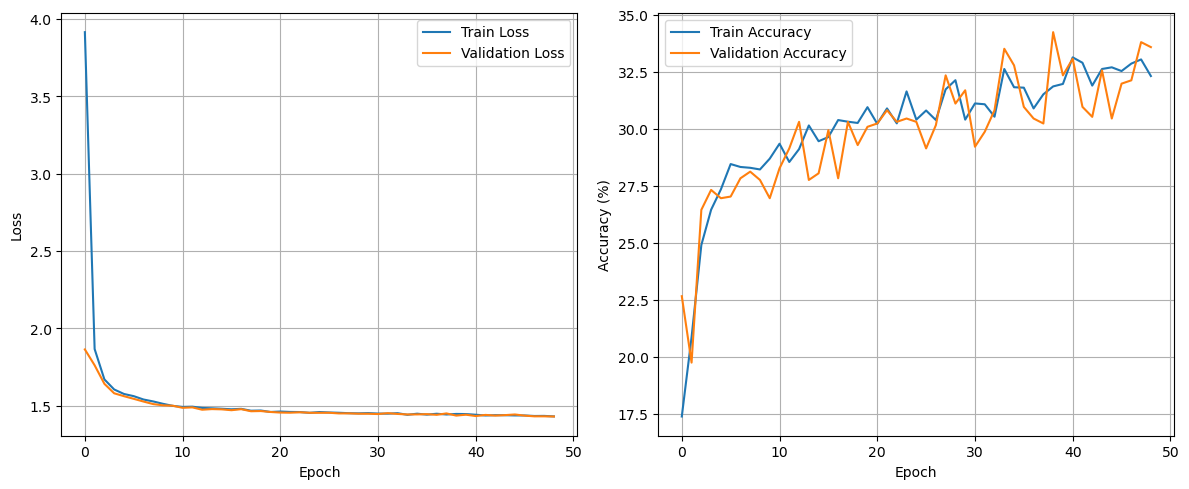

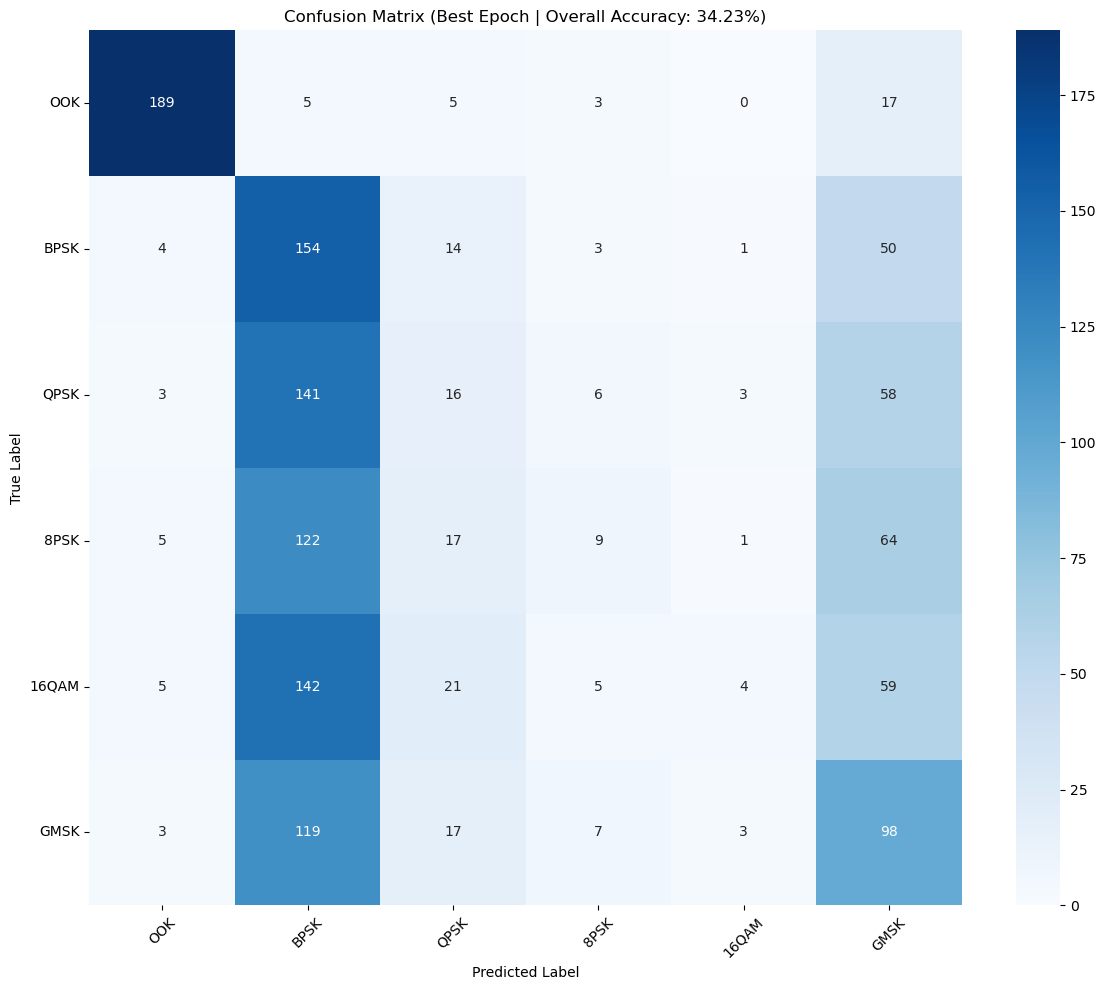

In [8]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    patience=5, 
    factor=0.5,
    verbose=True
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioML18Dataset('train', use_fft=True)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model2.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix.png')
plt.show()

In [9]:
class SignalAugmentation:
    """
    Comprehensive augmentation suite for I/Q signal processing
    Specifically designed for modulation classification
    """
    
    def __init__(self, config=None):
        # Default augmentation configuration
        self.config = config or {
            'noise_std_range': (0.01, 0.05),            # AWGN noise
            'snr_range': (-10, 30),                     # SNR variation
            'phase_shift_range': (-np.pi, np.pi),       # Phase rotation
            'amplitude_scale_range': (0.7, 1.3),        # Amplitude scaling
            'frequency_shift_range': (-0.1, 0.1),       # Frequency offset
            'time_shift_range': (-50, 50),              # Time shifting
            'iq_imbalance_range': (0.9, 1.1),           # I/Q imbalance
            'dc_offset_range': (-0.1, 0.1),             # DC offset
            'multipath_delay_range': (1, 10),           # Multipath fading
            'dropout_prob_range': (0.0, 0.02),          # Sample dropout
        }
    
    def add_awgn_noise(self, signal, probability=0.8):
        """Add Additive White Gaussian Noise"""
        if torch.rand(1).item() < probability:
            std_min, std_max = self.config['noise_std_range']
            noise_std = torch.empty(1).uniform_(std_min, std_max).item()
            
            # Add complex noise to both I and Q channels
            noise = torch.randn_like(signal) * noise_std
            return signal + noise
        return signal
    
    def snr_variation(self, signal, probability=0.6):
        """Simulate different SNR conditions"""
        if torch.rand(1).item() < probability:
            snr_min, snr_max = self.config['snr_range']
            target_snr_db = torch.empty(1).uniform_(snr_min, snr_max).item()
            
            # Calculate current signal power
            signal_power = torch.mean(signal ** 2)
            
            # Calculate required noise power for target SNR
            snr_linear = 10 ** (target_snr_db / 10)
            noise_power = signal_power / snr_linear
            
            # Add noise
            noise = torch.randn_like(signal) * torch.sqrt(noise_power)
            return signal + noise
        return signal
    
    def phase_rotation(self, signal, probability=0.7):
        """Apply random phase rotation (common in RF systems)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            phase_min, phase_max = self.config['phase_shift_range']
            phase_shift = torch.empty(1).uniform_(phase_min, phase_max).item()
            
            # Apply rotation matrix to I/Q
            cos_phi = np.cos(phase_shift)
            sin_phi = np.sin(phase_shift)
            
            i_rotated = signal[0] * cos_phi - signal[1] * sin_phi
            q_rotated = signal[0] * sin_phi + signal[1] * cos_phi
            
            return torch.stack([i_rotated, q_rotated], dim=0)
        return signal
    
    def amplitude_scaling(self, signal, probability=0.6):
        """Apply random amplitude scaling (AGC effects)"""
        if torch.rand(1).item() < probability:
            scale_min, scale_max = self.config['amplitude_scale_range']
            scale_factor = torch.empty(1).uniform_(scale_min, scale_max).item()
            return signal * scale_factor
        return signal
    
    def frequency_offset(self, signal, probability=0.5):
        """Simulate carrier frequency offset"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            freq_min, freq_max = self.config['frequency_shift_range']
            freq_offset = torch.empty(1).uniform_(freq_min, freq_max).item()
            
            # Create time vector
            seq_len = signal.size(1)
            t = torch.arange(seq_len, dtype=torch.float32) / seq_len
            
            # Apply frequency offset
            complex_offset = torch.exp(1j * 2 * np.pi * freq_offset * t)
            
            # Convert to I/Q and apply
            cos_offset = torch.real(complex_offset)
            sin_offset = torch.imag(complex_offset)
            
            i_shifted = signal[0] * cos_offset - signal[1] * sin_offset
            q_shifted = signal[0] * sin_offset + signal[1] * cos_offset
            
            return torch.stack([i_shifted, q_shifted], dim=0)
        return signal
    
    def time_shifting(self, signal, probability=0.4):
        """Apply random time shifts (timing offset)"""
        if torch.rand(1).item() < probability:
            shift_min, shift_max = self.config['time_shift_range']
            shift = torch.randint(shift_min, shift_max + 1, (1,)).item()
            
            if shift != 0:
                # Circular shift
                return torch.roll(signal, shifts=shift, dims=1)
        return signal
    
    def iq_imbalance(self, signal, probability=0.3):
        """Simulate I/Q imbalance (hardware imperfection)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            imb_min, imb_max = self.config['iq_imbalance_range']
            
            # Different scaling for I and Q channels
            i_scale = torch.empty(1).uniform_(imb_min, imb_max).item()
            q_scale = torch.empty(1).uniform_(imb_min, imb_max).item()
            
            signal_aug = signal.clone()
            signal_aug[0] *= i_scale  # I channel
            signal_aug[1] *= q_scale  # Q channel
            
            return signal_aug
        return signal
    
    def dc_offset(self, signal, probability=0.3):
        """Add DC offset (hardware bias)"""
        if torch.rand(1).item() < probability:
            offset_min, offset_max = self.config['dc_offset_range']
            
            # Different DC offset for each channel
            dc_i = torch.empty(1).uniform_(offset_min, offset_max).item()
            dc_q = torch.empty(1).uniform_(offset_min, offset_max).item()
            
            signal_aug = signal.clone()
            signal_aug[0] += dc_i
            signal_aug[1] += dc_q
            
            return signal_aug
        return signal
    
    def multipath_fading(self, signal, probability=0.2):
        """Simulate simple multipath fading"""
        if torch.rand(1).item() < probability:
            delay_min, delay_max = self.config['multipath_delay_range']
            delay = torch.randint(delay_min, delay_max + 1, (1,)).item()
            
            # Create delayed and attenuated copy
            attenuation = torch.empty(1).uniform_(0.1, 0.4).item()
            delayed_signal = torch.roll(signal, shifts=delay, dims=1) * attenuation
            
            return signal + delayed_signal
        return signal
    
    def sample_dropout(self, signal, probability=0.1):
        """Randomly drop some samples (simulate packet loss)"""
        if torch.rand(1).item() < probability:
            dropout_min, dropout_max = self.config['dropout_prob_range']
            dropout_prob = torch.empty(1).uniform_(dropout_min, dropout_max).item()
            
            # Create dropout mask
            mask = torch.rand(signal.size()) > dropout_prob
            return signal * mask
        return signal
    
    def spectral_inversion(self, signal, probability=0.2):
        """Apply spectral inversion (Q channel sign flip)"""
        if torch.rand(1).item() < probability and signal.size(0) == 2:
            signal_aug = signal.clone()
            signal_aug[1] *= -1  # Flip Q channel
            return signal_aug
        return signal
    
    def __call__(self, signal, augmentation_strength=1.0):
        """
        Apply random combination of augmentations
        
        Args:
            signal: Input I/Q signal tensor (2, seq_len)
            augmentation_strength: Float 0-1, controls how aggressive augmentation is
        """
        
        # Adjust probabilities based on strength
        strength_factor = min(max(augmentation_strength, 0.0), 1.0)
        
        # Apply augmentations in logical order
        augmented = signal.clone()
        
        # Hardware imperfections (apply early)
        augmented = self.dc_offset(augmented, probability=0.3 * strength_factor)
        augmented = self.iq_imbalance(augmented, probability=0.3 * strength_factor)
        
        # Channel effects
        augmented = self.phase_rotation(augmented, probability=0.7 * strength_factor)
        augmented = self.frequency_offset(augmented, probability=0.5 * strength_factor)
        augmented = self.amplitude_scaling(augmented, probability=0.6 * strength_factor)
        
        # Noise and interference
        augmented = self.add_awgn_noise(augmented, probability=0.8 * strength_factor)
        augmented = self.multipath_fading(augmented, probability=0.2 * strength_factor)
        
        # Timing effects
        augmented = self.time_shifting(augmented, probability=0.4 * strength_factor)
        
        # Digital effects
        augmented = self.sample_dropout(augmented, probability=0.1 * strength_factor)
        augmented = self.spectral_inversion(augmented, probability=0.2 * strength_factor)
        
        return augmented

In [10]:
def get_augmentation_presets():
    """
    Get predefined augmentation configurations for different scenarios
    """
    
    presets = {
        'conservative': {
            'noise_std_range': (0.005, 0.02),
            'snr_range': (0, 25),
            'phase_shift_range': (-np.pi/4, np.pi/4),
            'amplitude_scale_range': (0.8, 1.2),
            'frequency_shift_range': (-0.05, 0.05),
            'time_shift_range': (-20, 20),
            'iq_imbalance_range': (0.95, 1.05),
            'dc_offset_range': (-0.05, 0.05),
            'multipath_delay_range': (1, 5),
            'dropout_prob_range': (0.0, 0.01),
        },
        
        'moderate': {
            'noise_std_range': (0.01, 0.05),
            'snr_range': (-5, 30),
            'phase_shift_range': (-np.pi/2, np.pi/2),
            'amplitude_scale_range': (0.7, 1.3),
            'frequency_shift_range': (-0.1, 0.1),
            'time_shift_range': (-50, 50),
            'iq_imbalance_range': (0.9, 1.1),
            'dc_offset_range': (-0.1, 0.1),
            'multipath_delay_range': (1, 10),
            'dropout_prob_range': (0.0, 0.02),
        },
        
        'aggressive': {
            'noise_std_range': (0.02, 0.1),
            'snr_range': (-10, 35),
            'phase_shift_range': (-np.pi, np.pi),
            'amplitude_scale_range': (0.5, 1.5),
            'frequency_shift_range': (-0.2, 0.2),
            'time_shift_range': (-100, 100),
            'iq_imbalance_range': (0.8, 1.2),
            'dc_offset_range': (-0.2, 0.2),
            'multipath_delay_range': (1, 20),
            'dropout_prob_range': (0.0, 0.05),
        }
    }
    
    return presets

In [11]:
class RadioML18DatasetAugmented(Dataset):
    """
    Custom Dataset class for the RadioML2018.01.A dataset.
    Handles data loading, I/Q channel correction, optional FFT,
    and now includes optional Signal Augmentation for training data.
    """
    def __init__(self, mode: str, use_fft: bool = False, apply_augmentation: bool = False, augmentation_config=None, seed=48):
        super(RadioML18DatasetAugmented, self).__init__()

        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode

        # Augmentation setup
        self.apply_augmentation = apply_augmentation
        if self.apply_augmentation:
            self.augmentor = SignalAugmentation(config=augmentation_config)
            print(f"Dataset '{self.mode}' configured with Signal Augmentation.")
        else:
            self.augmentor = None
            print(f"Dataset '{self.mode}' configured WITHOUT Signal Augmentation.")


        try:
            hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except Exception as e: 
            print(f"Error loading file : {e}")
            raise e 
        
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]

        train_prop_ds = 0.7
        valid_prop_ds = 0.2
        test_prop_ds = 0.1

        self.target_snrs = np.unique(self.Z)

        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_prop_ds,
                                                                  valid_proportion = valid_prop_ds,
                                                                  test_proportion = test_prop_ds,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )
        
        print(f"🔧 Applying I/Q swap fix to {self.mode} dataset...")
        self.X_data = self.X_data[:,:,[1,0]] # Swapping I and Q channels
        print(f"✅ I/Q channels corrected for real-world compatibility for {self.mode} dataset.")
        
        if self.use_fft:
            print(f"Dataset '{self.mode}' configured to use FFT as input.")

        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x_raw, y, z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        
        # Convert to tensor and transpose to (channels, sequence length)
        x = torch.from_numpy(x_raw).float().transpose(0,1)

        # Apply augmentation ONLY for training mode if enabled
        if self.mode == 'train' and self.apply_augmentation and self.augmentor:
            x = self.augmentor(x, augmentation_strength=1.0) # Using full strength, can be tuned

        if self.use_fft: 
            complex_signal = torch.complex(x[0], x[1])
            fft_result = torch.fft.fft(complex_signal)
            fft_real = torch.real(fft_result)
            fft_imag = torch.imag(fft_result)
            x = torch.stack([fft_real, fft_imag], dim = 0)
        
        return x, y, z

In [12]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    patience=5, 
    factor=0.5,
    verbose=True
)
scaler = GradScaler()
# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioML18DatasetAugmented('train', use_fft=True, apply_augmentation=True,augmentation_config=get_augmentation_presets()['moderate'])  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size],
    generator=torch.Generator().manual_seed(42)  # For reproducible splits
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (80%)")
print(f"Validation dataset size: {len(valid_dataset)} (20%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_model2.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix FFT Apply (Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix.png')
plt.show()

/home/lipplopp/anaconda3/envs/ai_sdr/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_3412/499799999.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Loading datasets...
Dataset 'train' configured with Signal Augmentation.
🔧 Applying I/Q swap fix to train dataset...
✅ I/Q channels corrected for real-world compatibility for train dataset.
Dataset 'train' configured to use FFT as input.
Datasets loaded successfully.
Total dataset size: 447252
Train dataset size: 357801 (80%)
Validation dataset size: 89451 (20%)

Starting training...


Training:   0%|                    | 0/1398 [00:00<?, ?it/s]/tmp/ipykernel_3412/499799999.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Training: 100%|████████▉| 1394/1398 [02:18<00:00, 10.08it/s]
                                                            
Epochs:   1%|▎                               | 1/100 [02:42<4:28:39, 162.82s/it]

Epoch 1/100: Train Loss: 1.4288 | Train Acc: 34.26% | Valid Loss: 1.3675 | Valid Acc: 36.94%



Training:  99%|████████▉| 1389/1398 [02:18<00:00, 10.12it/s]
                                                            
Epochs:   2%|▋                               | 2/100 [05:26<4:26:17, 163.04s/it]

Epoch 2/100: Train Loss: 1.3696 | Train Acc: 37.17% | Valid Loss: 1.3092 | Valid Acc: 39.39%



Training: 100%|████████▉| 1397/1398 [02:19<00:00, 10.07it/s]
                                                            
Epochs:   3%|▉                               | 3/100 [08:09<4:23:57, 163.27s/it]

Epoch 3/100: Train Loss: 1.3401 | Train Acc: 38.32% | Valid Loss: 1.3113 | Valid Acc: 39.43%



Training: 100%|█████████| 1398/1398 [02:19<00:00, 10.11it/s]
                                                            
Epochs:   4%|█▎                              | 4/100 [10:52<4:21:12, 163.25s/it]

Epoch 4/100: Train Loss: 1.3310 | Train Acc: 38.65% | Valid Loss: 1.2947 | Valid Acc: 39.76%



Training:  99%|████████▉| 1391/1398 [02:18<00:00,  9.84it/s]
                                                            
Epochs:   5%|█▌                              | 5/100 [13:36<4:18:33, 163.30s/it]

Epoch 5/100: Train Loss: 1.3230 | Train Acc: 39.42% | Valid Loss: 1.2838 | Valid Acc: 41.31%



Training: 100%|████████▉| 1394/1398 [02:18<00:00, 10.11it/s]
                                                            
Epochs:   6%|█▉                              | 6/100 [16:18<4:15:31, 163.10s/it]

Epoch 6/100: Train Loss: 1.3133 | Train Acc: 40.18% | Valid Loss: 1.2821 | Valid Acc: 41.71%



Training:  99%|████████▉| 1389/1398 [02:18<00:00, 10.05it/s]
                                                            
Epochs:   7%|██▏                             | 7/100 [19:01<4:12:38, 163.00s/it]

Epoch 7/100: Train Loss: 1.2938 | Train Acc: 41.47% | Valid Loss: 1.2456 | Valid Acc: 43.93%



Training: 100%|████████▉| 1394/1398 [02:18<00:00, 10.11it/s]
                                                            
Epochs:   8%|██▌                             | 8/100 [21:44<4:09:42, 162.85s/it]

Epoch 8/100: Train Loss: 1.2625 | Train Acc: 43.22% | Valid Loss: 1.2149 | Valid Acc: 45.59%



Training: 100%|████████▉| 1392/1398 [02:18<00:00,  9.94it/s]
                                                            
Epochs:   9%|██▉                             | 9/100 [24:27<4:07:01, 162.88s/it]

Epoch 9/100: Train Loss: 1.2327 | Train Acc: 44.67% | Valid Loss: 1.1814 | Valid Acc: 47.46%



Training: 100%|████████▉| 1396/1398 [02:18<00:00, 10.08it/s]
                                                            
Epochs:  10%|███                            | 10/100 [27:10<4:04:27, 162.97s/it]

Epoch 10/100: Train Loss: 1.2045 | Train Acc: 46.00% | Valid Loss: 1.1311 | Valid Acc: 49.23%



Training:  99%|████████▉| 1389/1398 [02:18<00:00, 10.01it/s]
                                                            
Epochs:  11%|███▍                           | 11/100 [29:53<4:01:43, 162.96s/it]

Epoch 11/100: Train Loss: 1.1728 | Train Acc: 47.32% | Valid Loss: 1.1088 | Valid Acc: 49.45%



Training: 100%|████████▉| 1396/1398 [02:19<00:00,  9.94it/s]
                                                            
Epochs:  12%|███▋                           | 12/100 [32:36<3:59:06, 163.03s/it]

Epoch 12/100: Train Loss: 1.1480 | Train Acc: 48.19% | Valid Loss: 1.0815 | Valid Acc: 50.52%



Training: 100%|████████▉| 1395/1398 [02:18<00:00,  9.90it/s]
                                                            
Epochs:  13%|████                           | 13/100 [35:19<3:56:16, 162.95s/it]

Epoch 13/100: Train Loss: 1.1370 | Train Acc: 48.58% | Valid Loss: 1.0840 | Valid Acc: 50.26%



Training:  99%|████████▉| 1390/1398 [02:18<00:00,  9.95it/s]
                                                            
Epochs:  14%|████▎                          | 14/100 [38:02<3:53:33, 162.95s/it]

Epoch 14/100: Train Loss: 1.1275 | Train Acc: 48.75% | Valid Loss: 1.0736 | Valid Acc: 50.82%



Training:  99%|████████▉| 1390/1398 [02:18<00:00, 10.16it/s]
                                                            
Epochs:  15%|████▋                          | 15/100 [40:44<3:50:45, 162.89s/it]

Epoch 15/100: Train Loss: 1.1222 | Train Acc: 49.01% | Valid Loss: 1.0479 | Valid Acc: 51.79%



Training: 100%|████████▉| 1395/1398 [02:18<00:00, 10.06it/s]
                                                            
Epochs:  16%|████▉                          | 16/100 [43:27<3:47:49, 162.74s/it]

Epoch 16/100: Train Loss: 1.1156 | Train Acc: 49.37% | Valid Loss: 1.0521 | Valid Acc: 51.75%



Training: 100%|████████▉| 1392/1398 [02:18<00:00, 10.13it/s]
                                                            
Epochs:  17%|█████▎                         | 17/100 [46:10<3:45:08, 162.75s/it]

Epoch 17/100: Train Loss: 1.1123 | Train Acc: 49.46% | Valid Loss: 1.0472 | Valid Acc: 51.82%



Training:  99%|████████▉| 1390/1398 [02:18<00:00,  9.97it/s]
                                                            
Epochs:  18%|█████▌                         | 18/100 [48:53<3:42:31, 162.83s/it]

Epoch 18/100: Train Loss: 1.1059 | Train Acc: 49.71% | Valid Loss: 1.0561 | Valid Acc: 50.22%



Training: 100%|████████▉| 1397/1398 [02:18<00:00,  9.90it/s]
                                                            
Epochs:  19%|█████▉                         | 19/100 [51:36<3:40:13, 163.12s/it]

Epoch 19/100: Train Loss: 1.1036 | Train Acc: 49.81% | Valid Loss: 1.0522 | Valid Acc: 51.61%



Training: 100%|█████████| 1398/1398 [02:18<00:00, 10.10it/s]
                                                            
Epochs:  20%|██████▏                        | 20/100 [54:19<3:37:20, 163.00s/it]

Epoch 20/100: Train Loss: 1.1033 | Train Acc: 49.88% | Valid Loss: 1.0587 | Valid Acc: 51.05%



Training:  99%|████████▉| 1389/1398 [02:18<00:00,  9.88it/s]
                                                            
Epochs:  21%|██████▌                        | 21/100 [57:02<3:34:32, 162.94s/it]

Epoch 21/100: Train Loss: 1.0993 | Train Acc: 49.96% | Valid Loss: 1.0410 | Valid Acc: 52.10%



Training: 100%|████████▉| 1395/1398 [02:18<00:00,  9.89it/s]
                                                            
Epochs:  22%|██████▊                        | 22/100 [59:45<3:31:41, 162.85s/it]

Epoch 22/100: Train Loss: 1.0977 | Train Acc: 50.04% | Valid Loss: 1.0583 | Valid Acc: 50.54%



Training:  99%|████████▉| 1388/1398 [02:17<00:00, 10.05it/s]
                                                            
Epochs:  23%|██████▋                      | 23/100 [1:02:27<3:28:54, 162.79s/it]

Epoch 23/100: Train Loss: 1.0940 | Train Acc: 50.14% | Valid Loss: 1.0547 | Valid Acc: 51.19%



Training: 100%|████████▉| 1393/1398 [02:18<00:00, 10.21it/s]
                                                            
Epochs:  24%|██████▉                      | 24/100 [1:05:10<3:26:10, 162.77s/it]

Epoch 24/100: Train Loss: 1.0940 | Train Acc: 50.12% | Valid Loss: 1.0463 | Valid Acc: 51.77%



Training:  99%|████████▉| 1390/1398 [02:16<00:00, 10.09it/s]
                                                            
Epochs:  25%|███████▎                     | 25/100 [1:07:51<3:22:54, 162.33s/it]

Epoch 25/100: Train Loss: 1.0921 | Train Acc: 50.22% | Valid Loss: 1.0446 | Valid Acc: 51.67%



Training: 100%|████████▉| 1396/1398 [02:16<00:00, 10.18it/s]
                                                            
Epochs:  26%|███████▌                     | 26/100 [1:10:32<3:19:34, 161.81s/it]

Epoch 26/100: Train Loss: 1.0900 | Train Acc: 50.31% | Valid Loss: 1.0342 | Valid Acc: 52.29%



Training: 100%|█████████| 1398/1398 [02:18<00:00, 10.29it/s]
                                                            
Epochs:  27%|███████▊                     | 27/100 [1:13:14<3:17:00, 161.92s/it]

Epoch 27/100: Train Loss: 1.0876 | Train Acc: 50.24% | Valid Loss: 1.0431 | Valid Acc: 52.02%



Training: 100%|████████▉| 1394/1398 [02:17<00:00,  9.97it/s]
                                                            
Epochs:  28%|████████                     | 28/100 [1:15:56<3:14:20, 161.96s/it]

Epoch 28/100: Train Loss: 1.0870 | Train Acc: 50.37% | Valid Loss: 1.1032 | Valid Acc: 46.76%



Training: 100%|████████▉| 1396/1398 [02:18<00:00, 10.07it/s]
                                                            
Epochs:  29%|████████▍                    | 29/100 [1:18:39<3:11:51, 162.13s/it]

Epoch 29/100: Train Loss: 1.0883 | Train Acc: 50.35% | Valid Loss: 1.0600 | Valid Acc: 49.28%



Training:  99%|████████▉| 1390/1398 [02:18<00:00,  9.86it/s]
                                                            
Epochs:  30%|████████▋                    | 30/100 [1:21:21<3:09:24, 162.35s/it]

Epoch 30/100: Train Loss: 1.0856 | Train Acc: 50.47% | Valid Loss: 1.0523 | Valid Acc: 51.27%



Training: 100%|████████▉| 1394/1398 [02:18<00:00, 10.03it/s]
                                                            
Epochs:  31%|████████▉                    | 31/100 [1:24:04<3:06:49, 162.46s/it]

Epoch 31/100: Train Loss: 1.0851 | Train Acc: 50.48% | Valid Loss: 1.0346 | Valid Acc: 52.13%



Training:  99%|████████▉| 1391/1398 [02:18<00:00, 10.00it/s]
                                                            
Epochs:  32%|█████████▎                   | 32/100 [1:26:47<3:04:14, 162.57s/it]

Epoch 32/100: Train Loss: 1.0842 | Train Acc: 50.50% | Valid Loss: 1.0479 | Valid Acc: 51.98%



Training: 100%|████████▉| 1395/1398 [02:18<00:00, 10.18it/s]
                                                            
Epochs:  33%|█████████▌                   | 33/100 [1:29:30<3:01:31, 162.56s/it]

Epoch 33/100: Train Loss: 1.0703 | Train Acc: 50.98% | Valid Loss: 1.0211 | Valid Acc: 52.75%



Training: 100%|████████▉| 1392/1398 [02:17<00:00, 10.15it/s]
                                                            
Epochs:  34%|█████████▊                   | 34/100 [1:32:12<2:58:50, 162.59s/it]

Epoch 34/100: Train Loss: 1.0668 | Train Acc: 51.18% | Valid Loss: 1.0196 | Valid Acc: 53.17%



Training: 100%|████████▉| 1394/1398 [02:17<00:00, 10.22it/s]
                                                            
Epochs:  35%|██████████▏                  | 35/100 [1:34:54<2:55:58, 162.44s/it]

Epoch 35/100: Train Loss: 1.0652 | Train Acc: 51.24% | Valid Loss: 1.0363 | Valid Acc: 51.46%



Training: 100%|████████▉| 1393/1398 [02:17<00:00, 10.02it/s]
                                                            
Epochs:  36%|██████████▍                  | 36/100 [1:37:36<2:53:11, 162.36s/it]

Epoch 36/100: Train Loss: 1.0649 | Train Acc: 51.35% | Valid Loss: 1.0229 | Valid Acc: 53.11%



Training: 100%|████████▉| 1393/1398 [02:17<00:00, 10.01it/s]
                                                            
Epochs:  37%|██████████▋                  | 37/100 [1:40:19<2:50:24, 162.30s/it]

Epoch 37/100: Train Loss: 1.0645 | Train Acc: 51.38% | Valid Loss: 1.0399 | Valid Acc: 51.55%



Training:  99%|████████▉| 1389/1398 [02:16<00:00, 10.20it/s]
                                                            
Epochs:  38%|███████████                  | 38/100 [1:43:00<2:47:31, 162.11s/it]

Epoch 38/100: Train Loss: 1.0643 | Train Acc: 51.18% | Valid Loss: 1.0435 | Valid Acc: 50.47%



Training: 100%|████████▉| 1397/1398 [02:17<00:00, 10.10it/s]
                                                            
Epochs:  39%|███████████▎                 | 39/100 [1:45:42<2:44:44, 162.04s/it]

Epoch 39/100: Train Loss: 1.0636 | Train Acc: 51.35% | Valid Loss: 1.0134 | Valid Acc: 53.49%



Training:  99%|████████▉| 1388/1398 [02:15<00:01,  9.95it/s]
                                                            
Epochs:  40%|███████████▌                 | 40/100 [1:48:23<2:41:32, 161.55s/it]

Epoch 40/100: Train Loss: 1.0627 | Train Acc: 51.39% | Valid Loss: 1.0368 | Valid Acc: 50.52%



Training:  99%|████████▉| 1388/1398 [02:17<00:00, 10.02it/s]
                                                            
Epochs:  41%|███████████▉                 | 41/100 [1:51:04<2:38:57, 161.66s/it]

Epoch 41/100: Train Loss: 1.0619 | Train Acc: 51.38% | Valid Loss: 1.0256 | Valid Acc: 52.40%



Training: 100%|████████▉| 1397/1398 [02:18<00:00,  9.91it/s]
                                                            
Epochs:  42%|████████████▏                | 42/100 [1:53:47<2:36:24, 161.80s/it]

Epoch 42/100: Train Loss: 1.0614 | Train Acc: 51.48% | Valid Loss: 1.0282 | Valid Acc: 52.12%



Training: 100%|█████████| 1398/1398 [02:18<00:00, 10.03it/s]
                                                            
Epochs:  43%|████████████▍                | 43/100 [1:56:29<2:33:47, 161.89s/it]

Epoch 43/100: Train Loss: 1.0610 | Train Acc: 51.45% | Valid Loss: 1.0152 | Valid Acc: 53.33%



Training: 100%|████████▉| 1396/1398 [02:17<00:00, 10.02it/s]
                                                            
Epochs:  44%|████████████▊                | 44/100 [1:59:11<2:31:06, 161.90s/it]

Epoch 44/100: Train Loss: 1.0606 | Train Acc: 51.44% | Valid Loss: 1.0385 | Valid Acc: 50.52%



Training: 100%|████████▉| 1395/1398 [02:17<00:00, 10.09it/s]
                                                            
Epochs:  45%|█████████████                | 45/100 [2:01:52<2:28:22, 161.86s/it]

Epoch 45/100: Train Loss: 1.0617 | Train Acc: 51.29% | Valid Loss: 1.0129 | Valid Acc: 53.57%



Training: 100%|████████▉| 1393/1398 [02:18<00:00,  9.98it/s]
                                                            
Epochs:  46%|█████████████▎               | 46/100 [2:04:36<2:26:00, 162.24s/it]

Epoch 46/100: Train Loss: 1.0603 | Train Acc: 51.47% | Valid Loss: 1.0179 | Valid Acc: 53.11%



Training:  99%|████████▉| 1391/1398 [02:17<00:00,  9.98it/s]
                                                            
Epochs:  47%|█████████████▋               | 47/100 [2:07:18<2:23:20, 162.27s/it]

Epoch 47/100: Train Loss: 1.0607 | Train Acc: 51.30% | Valid Loss: 1.0148 | Valid Acc: 53.20%



Training: 100%|████████▉| 1396/1398 [02:18<00:00, 10.03it/s]
                                                            
Epochs:  48%|█████████████▉               | 48/100 [2:10:00<2:20:38, 162.28s/it]

Epoch 48/100: Train Loss: 1.0597 | Train Acc: 51.48% | Valid Loss: 1.0186 | Valid Acc: 53.23%



Training: 100%|████████▉| 1393/1398 [02:17<00:00, 10.13it/s]
                                                            
Epochs:  49%|██████████████▏              | 49/100 [2:12:42<2:17:55, 162.27s/it]

Epoch 49/100: Train Loss: 1.0601 | Train Acc: 51.42% | Valid Loss: 1.0177 | Valid Acc: 53.21%



Training:  99%|████████▉| 1390/1398 [02:18<00:00, 10.00it/s]
                                                            
Epochs:  50%|██████████████▌              | 50/100 [2:15:25<2:15:22, 162.44s/it]

Epoch 50/100: Train Loss: 1.0589 | Train Acc: 51.44% | Valid Loss: 1.0530 | Valid Acc: 49.65%



Training:  99%|████████▉| 1390/1398 [02:18<00:00,  9.84it/s]
                                                            
Epochs:  51%|██████████████▊              | 51/100 [2:18:08<2:12:48, 162.62s/it]

Epoch 51/100: Train Loss: 1.0578 | Train Acc: 51.56% | Valid Loss: 1.0243 | Valid Acc: 52.85%



Training:  99%|████████▉| 1391/1398 [02:18<00:00, 10.06it/s]
                                                            
Epochs:  52%|███████████████              | 52/100 [2:20:51<2:10:07, 162.65s/it]

Epoch 52/100: Train Loss: 1.0519 | Train Acc: 51.72% | Valid Loss: 1.0138 | Valid Acc: 53.17%



Epochs:  52%|███████████████              | 52/100 [2:22:33<2:11:35, 164.49s/it]


KeyboardInterrupt: 